<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./22_ltpy_v01_AC_SAF_GOME-2_L3.ipynb"><< 22 - AC SAF - GOME-2 - Level 3 </a><span style="float:right;"><a href="./24_ltpy_v01_CAMS_data.ipynb">24 - Copernicus Atmosphere Monitoring Service (CAMS) data >></a></span>

# 2.3 Copernicus Sentinel-5 Precursor (Sentinel-5P)

A precursor satellite mission, Sentinel-5P aims to fill in the data gap and provide data continuity between the retirement of the Envisat satellite and NASA's Aura mission and the launch of Sentinel-5. The Copernicus Sentinel-5P mission is being used to closely monitor the changes in air quality and was launched in October 2017.

Sentinel-5p Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/).

Sentinel-5p carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on:
* `Ozone`
* `NO`<sub>`2`</sub>
* `SO`<sub>`2`</sub>
* `Formaldehyde`
* `Aerosol`
* `Carbonmonoxide`
* `Methane`
* `Clouds`

#### Module outline:
* [1 - Load and browse Sentinel-5P data](#load_s5p)
* [2 - Plotting example - Sentinel-5P data](#plotting_s5p)
* [3 - Retrieve and visualize Sentinel-5P data with a Web Coverage Service from the TOP platform](#wcs_s5p)

#### Load required libraries

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import geopandas as gpd

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

<hr>

## <a id="load_s5p"></a>Load and browse Sentinel-5P data

### Open one individual Sentinel-5P netCDF file with `NetCDF4`

The dataset object contains information about the general data structure of the dataset. You can see that the variables of `Sentinel-5P` data are organised in groups, which is analogous to directories in a filesystem.

In [2]:
s5p_file = nc.Dataset('./eodata/sentinel5p/co/2019/08/19/S5P_OFFL_L2__CO_____20190819T164807_20190819T182937_09581_01_010302_20190825T161022.nc', 'r')
s5p_file.groups

OrderedDict([('PRODUCT', <class 'netCDF4._netCDF4.Group'>
              group /PRODUCT:
                  dimensions(sizes): scanline(4173), ground_pixel(215), corner(4), time(1), layer(50)
                  variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), float32 layer(layer), int32 delta_time(time,scanline), <class 'str'> time_utc(time,scanline), uint8 qa_value(time,scanline,ground_pixel), float32 latitude(time,scanline,ground_pixel), float32 longitude(time,scanline,ground_pixel), float32 carbonmonoxide_total_column(time,scanline,ground_pixel), float32 carbonmonoxide_total_column_precision(time,scanline,ground_pixel)
                  groups: SUPPORT_DATA),
             ('METADATA', <class 'netCDF4._netCDF4.Group'>
              group /METADATA:
                  dimensions(sizes): 
                  variables(dimensions): 
                  groups: QA_STATISTICS, ALGORITHM_SETTINGS, GRANULE_DESCRIPTION, ISO_ME

<br>

If you select the `/PRODUCT` group, you get more information on what variables the dataset object contain.

In [3]:
s5p_file.groups['PRODUCT']

<class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): scanline(4173), ground_pixel(215), corner(4), time(1), layer(50)
    variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), float32 layer(layer), int32 delta_time(time,scanline), <class 'str'> time_utc(time,scanline), uint8 qa_value(time,scanline,ground_pixel), float32 latitude(time,scanline,ground_pixel), float32 longitude(time,scanline,ground_pixel), float32 carbonmonoxide_total_column(time,scanline,ground_pixel), float32 carbonmonoxide_total_column_precision(time,scanline,ground_pixel)
    groups: SUPPORT_DATA

<br>

You see that the object contains the following variables:
* `scanline`
* `ground_pixel`
* `time`
* `corner`
* `delta_time`
* `time_utc`
* `ga_value`
* `latitude`
* `longitude`
* `carbonmonoxide_total_column`
* `carbonmonoxie_total_column_precision`

You can specify one variable of interest and get more detailed information about the variable. E.g. `carbonmonoxide_total_column` is the atmosphere mole content of carbon monoxide, has the unit mol m<sup>-2</sup>, and is a 3D variable.

You can do this for the available variables, but also for the dimensions latitude and longitude.
You can see e.g. that the `latitude` coordinates range between -85.9 S and 61.9 S and the `longitude` coordinates range between -124.3 W to 101.9 E.

In [4]:
co = s5p_file.groups['PRODUCT'].variables['carbonmonoxide_total_column']
lon = s5p_file.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lat = s5p_file.groups['PRODUCT'].variables['latitude'][:][0,:,:]

co, lon, lat

(<class 'netCDF4._netCDF4.Variable'>
 float32 carbonmonoxide_total_column(time, scanline, ground_pixel)
     units: mol m-2
     standard_name: atmosphere_mole_content_of_carbon_monoxide
     long_name: Vertically integrated CO column
     coordinates: longitude latitude
     ancillary_variables: carbonmonoxide_total_column_precision
     multiplication_factor_to_convert_to_molecules_percm2: 6.022141e+19
     _FillValue: 9.96921e+36
 path = /PRODUCT
 unlimited dimensions: 
 current shape = (1, 4173, 215)
 filling on, masked_array(
   data=[[-124.286896, -121.57894 , -118.606606, ...,   30.196842,
            30.417147,   30.642838],
         [-123.67012 , -120.92631 , -117.92033 , ...,   30.052769,
            30.27508 ,   30.502825],
         [-123.06039 , -120.28232 , -117.2446  , ...,   29.908726,
            30.133034,   30.36283 ],
         ...,
         [ 146.06601 ,  145.55302 ,  145.06328 , ...,  103.12766 ,
           102.50389 ,  101.846214],
         [ 146.01447 ,  145.50179

<br>

You can retrieve the array values of the variable object by selecting the `time` dimension and `data`. You can have a look at the `minimum` and `maximum` data value to get an idea of the data range. You see that the data contain negative values. Let's mask the negative values and all values equal to the `_FillValue` and set it to `NaN`. `_FillValue` is used for not significant data. Thus, you want to mask those.

In [5]:
co_data = co[0,:,:].data
print(co_data.min(), co_data.max())

-0.08076658 9.96921e+36


In [6]:
co_data[co_data <= 0.] = co._FillValue
co_data[co_data == co._FillValue] = np.nan

<br>

## <a id="plotting_s5p"></a>Plotting example - Sentinel-5P data

### Plot `Dataset` NetCDF library object with `matplotlib` and `cartopy`

The retrieved data array from the Dataset NetCDF object is of type `numpy array` and you can plot it with matplotlib's `pcolormesh` function. Due to the nature of the `CO` data values, we apply a logarithmic scale to the color bar with `LogNorm` from `matplotlib.colors`, which facilitates the visualisation of the data.

Let's create a function [visualize_s5p_pcolormesh](./ltpy_functions.ipynb#visualize_s5p_pcolormesh), where we can specify projection, extent, conversion_factor, color_scale, unit, title and if the plot shall have a global extent.

In [7]:
def visualize_s5p_pcolormesh(data_array, longitude, latitude, projection, color_scale, unit, long_name, lonmin, lonmax, latmin, latmax, set_global=True):
    """ 
    Visualizes a numpy array with matplotlib's 'pcolormesh' function.
    
    Parameters:
        data_array: any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        longitude: numpy MaskedArray containing longitude information
        latitude: numpy MaskedArray containing latitude information
        projection: a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
        color_scale(str): string taken from matplotlib's color ramp reference
        unit(str): the unit of the pararmeter
        long_name(str): long name of the parameter, taken from the NetCDF file if possible
        longmin,lonmax,latmin,latmax: geographic extent of the plot
        set_global: set True, if the plot shall have a global coverage
    """
    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=projection)

    # define the coordinate system that the grid lons and grid lats are on
    img = plt.pcolormesh(longitude, latitude, np.squeeze(data_array), norm=LogNorm(), cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree())

    ax.coastlines()

    if(set_global):
        ax.set_global()
        ax.gridlines()
    else:
        ax.set_extent([lonmin, lonmax, latmin, latmax], projection)
        gl = ax.gridlines(draw_labels=True, linestyle='--')
        gl.xlabels_top=False
        gl.ylabels_right=False
        gl.xformatter=LONGITUDE_FORMATTER
        gl.yformatter=LATITUDE_FORMATTER
        gl.xlabel_style={'size':12}
        gl.ylabel_style={'size':12}

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(long_name, fontsize=20, pad=20.0)

    plt.show()

You can retrieve unit and title information from the load `Dataset`, where the information is stored as attributes. You can now plot the data.

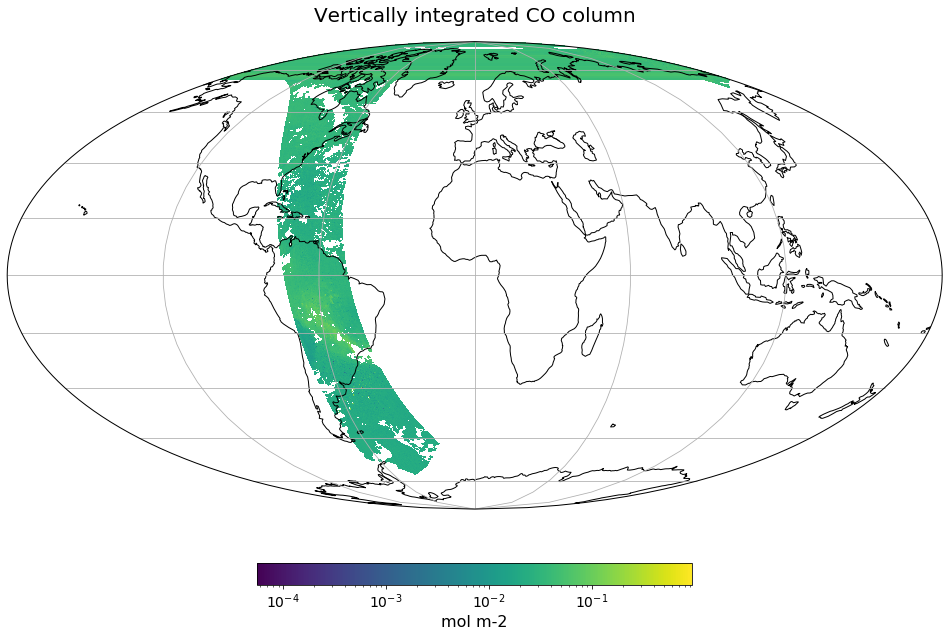

In [8]:
unit = co.units
long_name = co.long_name

visualize_s5p_pcolormesh(co_data, lon, lat, ccrs.Mollweide(), 'viridis', unit, long_name, lon.min(), lon.max(), lat.min(), lat.max(), set_global=True)

<br>

You can zoom into a region by specifying a `bounding box` of interest. Let's set the extent to South America, with: `[-100, 0, -80, 40]`. The above plotting function `visualize_s5p_pcolormesh` allows for setting a specific bounding box. You simply have to set the `set_global` key to False. It is best to adjust the projection to `PlateCarree()`, as this will be more appropriate for a regional subset.

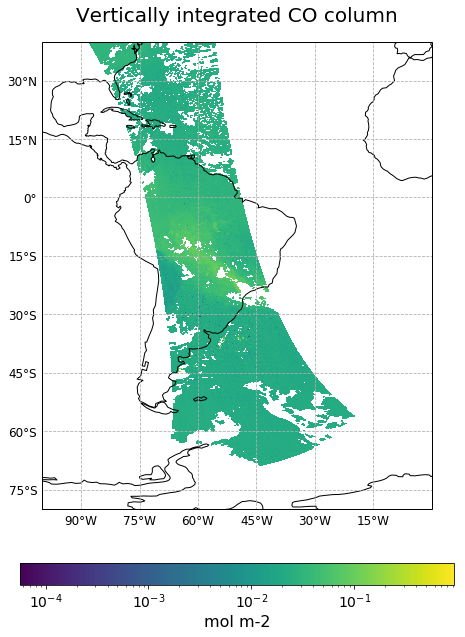

In [9]:
lonmin=-100
lonmax=0
latmin=-80
latmax=40

visualize_s5p_pcolormesh(co_data, lon, lat, ccrs.PlateCarree(), 'viridis', unit, long_name, lonmin, lonmax, latmin, latmax, set_global=False)

<br>

### Load multiple Sentinel-5p data files with `xarray` and `open_mfdataset`

The plots above showed the extent of one Sentinel-5P ground track. You can load multiple ground tracks into a single `xarray` and the `DataArrays` will be concatenated at the `scanline` dimension. This allows you to have a larger region of interest (ROI).

In [10]:
s5p_mf_19 = xr.open_mfdataset('./eodata/sentinel5p/co/2019/08/19/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf_19

<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 215, layer: 50, scanline: 16692, time: 1)
Coordinates:
  * layer                                  (layer) float32 49500.0 ... 500.0
  * time                                   (time) datetime64[ns] 2019-08-19
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
    latitude                               (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    longitude                              (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
Data variables:
    delta_time                             (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4173), meta=np.ndarray>
    time_utc                               (time, scanline

<br>

From the `Dataset` object `s5p_mf_19`, you can choose the data variable of interest, e.g. `carbonmonoxide_total_column`. It has three dimensions (`3D`), but the time dimension consisting only of one dimension entry. If you want to reduce it by the dimension time, you can simply select the first dimension and reduce it to a `2D` object. You can again use the function `visualize_s5p_pcolormesh` to visualize the data.

In [11]:
co_19 = s5p_mf_19.carbonmonoxide_total_column[0,:,:]
lat_19 = co_19.latitude
lon_19 = co_19.longitude

unit = co_19.units
long_name = co_19.long_name

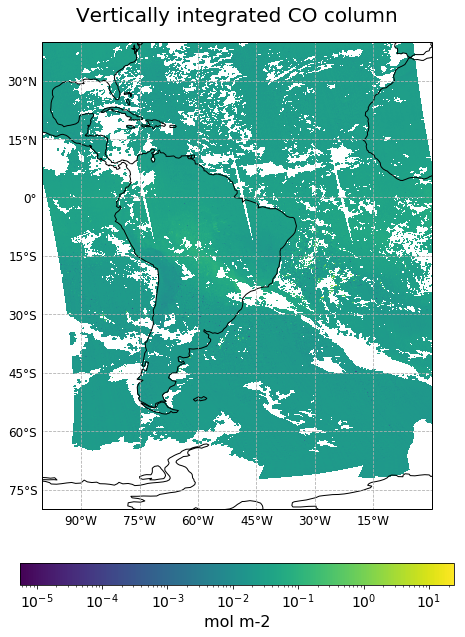

In [12]:
visualize_s5p_pcolormesh(co_19, lon_19, lat_19, ccrs.PlateCarree(), 'viridis', unit, long_name, lonmin, lonmax, latmin, latmax, set_global=False)


<br>

<hr>

## <a id="wcs_s5p"></a>Retrieve and visualize Sentinel-5P data with a Web Coverage Service from the TOP platform

A `Web Coverage Service (WCS)` defined by the `Open Geospatial Consortium (OGC)` allows for a standardised on-demand data access, without the need to download multiple GBs of data. The [Technology and atmospheric mission operations platform - (TOP platform)](https://top-platform.eu) offers a Web Coverage Service protocol to access global Sentinel-5p data.

In [ ]:
%run './adampy.py'

In [ ]:
import adampy as adam

<br>

With two lines, you can specify the time range and the Sentinel-5P collection parameter you are interested in. With the `getImageSentinel5p` function, you can then retrieve the data without the need to download it. The data values are returned as a `numpy` array and a dictionary with additional metadata.


In [ ]:
collection = 'vr_S5P_OFFLNRTI_L2__CO'
time_t = '2019-08-18T00:00:00,2019-08-18T23:59:59'

image, metadata = adam.getImageSentinel5p('wcs.top-platform.eu', collection, time_t, scale = 0.1).get_data()
image, metadata

<br>

You can make use of the function `visualize_imshow`, which was defined in the module [22_ltpy_v01_AC_SAF_GOME-2_L3](./22_ltpy_v01_AC_SAF_GOME-2_L3.ipynb), but youhave to adjust it for Sentinel-5P Carbonmonoxide values. Instead of specifying a minimum and maximum of the color range, you can add `norm=LogNorm()`, to allow for a logarithmic scaling.

In [ ]:
def visualize_imshow(data_array, projection, extent, color_scale, unit, long_name, set_global=False):
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=projection)
    ax.coastlines()
    ax.gridlines()
    if(set_global):
        ax.set_global()

    ax.set_title(long_name, fontsize=20, pad=20.0)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    img1 = plt.imshow(data_array[:],
           extent=extent,
           cmap=color_scale,
           norm=LogNorm(),
           transform=ccrs.PlateCarree())

    cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    plt.show()

<br>

From the `metadata` object, we can retrieve the `bounding box` information in order to set the extent of the plot.

In [ ]:
bbox = metadata['bbox']
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
unit = 'mol / m-2'
long_name = 'Vertically integrated column of carbon monoxide'

visualize_imshow(image, ccrs.PlateCarree(), extent, 'viridis', unit, long_name, set_global=False)

<br>

<a href="./22_ltpy_v01_AC_SAF_GOME-2_L3.ipynb"><< 22 - AC SAF - GOME-2 - Level 3 </a><span style="float:right;"><a href="./24_ltpy_v01_CAMS_data.ipynb">24 - Copernicus Atmosphere Monitoring Service (CAMS) data >></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>